In [47]:
import numpy as np
import pennylane as qml
from pennylane import numpy as qnp
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import glob
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [48]:
# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [49]:
# Configuration
n_qubits = 4  # Number of qubits for quantum circuit
n_layers = 2  # Number of random layers in quantum circuit
image_size = (128, 128)  # Original image size
q_image_size = (32, 32)  # Reduced size for quantum processing
batch_size = 16
n_epochs = 30
device_name = 'default.qubit'  # PennyLane quantum device

In [50]:
class BrainMRIDataset:
    """Class to manage Brain MRI dataset for quantum processing"""
    
    def __init__(self, data_dir="../data/brain_tumor_dataset"):
        self.data_dir = data_dir
        self.tumor_dir = os.path.join(data_dir, "yes")
        self.healthy_dir = os.path.join(data_dir, "no")
        self.images = []
        self.labels = []
        self.load_data()
        
    def load_data(self):
        """Load images and labels from the dataset directories"""
        # Load tumor images
        tumor_images = []
        for f in glob.iglob(os.path.join(self.tumor_dir, "*.jpg")):
            img = cv2.imread(f)
            if img is None:
                print(f"Warning: Could not read image {f}")
                continue
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            tumor_images.append(img)
        
        # Load healthy images
        healthy_images = []
        for f in glob.iglob(os.path.join(self.healthy_dir, "*.jpg")):
            img = cv2.imread(f)
            if img is None:
                print(f"Warning: Could not read image {f}")
                continue
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            healthy_images.append(img)
        
        print(f"Loaded {len(tumor_images)} tumor images and {len(healthy_images)} healthy images")
        
        # Prepare labels
        tumor_labels = np.ones(len(tumor_images))
        healthy_labels = np.zeros(len(healthy_images))
        
        # Combine and convert to numpy arrays
        self.images = np.array(tumor_images + healthy_images, dtype=np.float32)
        self.labels = np.concatenate((tumor_labels, healthy_labels))
        
        # Normalize images to [0, 1]
        self.images = self.images / 255.0
        
        # Shuffle the dataset
        indices = np.arange(len(self.images))
        np.random.shuffle(indices)
        self.images = self.images[indices]
        self.labels = self.labels[indices]
        
    def preprocess_for_quantum(self):
        """Preprocess images for quantum processing by downsampling"""
        print("Preprocessing images for quantum computing...")
        downsampled_images = []
        
        for img in self.images:
            # Convert to grayscale to reduce dimensionality
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # Resize to smaller dimensions for quantum processing
            small = cv2.resize(gray, q_image_size)
            # Normalize again to [0, 1]
            small = small / 255.0
            downsampled_images.append(small)
        
        return np.array(downsampled_images, dtype=np.float32)
    
    def plot_samples(self, num_samples=5):
        """Plot random samples from each class"""
        tumor_indices = [i for i, label in enumerate(self.labels) if label == 1]
        healthy_indices = [i for i, label in enumerate(self.labels) if label == 0]
        
        tumor_samples = np.random.choice(tumor_indices, min(num_samples, len(tumor_indices)), replace=False)
        healthy_samples = np.random.choice(healthy_indices, min(num_samples, len(healthy_indices)), replace=False)
        
        # Plot tumor samples
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(tumor_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(self.images[idx])
            plt.title('Tumor')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Plot healthy samples
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(healthy_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(self.images[idx])
            plt.title('Healthy')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [51]:
def create_quantum_circuit(n_qubits, n_layers):
    """Create a quantum circuit with random layers for the quantum convolution"""
    # Use a consistent random seed for reproducibility
    np.random.seed(RANDOM_SEED)
    
    # Create a quantum device
    dev = qml.device(device_name, wires=n_qubits)
    
    # Random circuit parameters
    rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))
    
    @qml.qnode(dev)
    def circuit(phi):
        # Encode classical input values
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)
        
        # Apply random quantum circuit
        RandomLayers(rand_params, wires=list(range(n_qubits)))
        
        # Measure in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]
    
    return circuit

In [52]:
def quantum_convolution(image, circuit, step=2):
    """
    Apply quantum convolution to the input image.
    
    Args:
        image: Input image of shape (height, width)
        circuit: Quantum circuit function
        step: Step size for moving the convolution window
    
    Returns:
        Quantum convolved image
    """
    h, w = image.shape
    q_h, q_w = h // step, w // step
    out = np.zeros((q_h, q_w, n_qubits))
    
    for j in range(0, h - step + 1, step):
        for k in range(0, w - step + 1, step):
            # Normalize patch values to [0, 1] range for better encoding
            patch = [
                image[j, k],
                image[j, k + 1],
                image[j + 1, k],
                image[j + 1, k + 1]
            ]
            
            # Scale inputs for better quantum encoding
            patch = [np.pi * val for val in patch]
            
            # Apply quantum circuit and get expectation values
            q_results = circuit(patch)
            
            for c in range(n_qubits):
                out[j // step, k // step, c] = q_results[c]
    
    return out

In [53]:
def process_dataset(images, circuit):
    """
    Process the entire dataset using quantum convolution.
    
    Args:
        images: Array of images (num_samples, height, width)
        circuit: Quantum circuit for convolution
    
    Returns:
        Quantum processed images
    """
    q_images = []
    print("Applying quantum convolution to images...")
    for i, img in enumerate(images):
        if i % 10 == 0:
            print(f"Processing image {i+1}/{len(images)}")
        q_img = quantum_convolution(img, circuit)
        q_images.append(q_img)
    
    return np.array(q_images)

In [62]:
def create_hybrid_model(input_shape):
    """
    Create a hybrid quantum-classical model.
    The first part is quantum (already applied to the images),
    and the second part is a classical neural network.
    
    Args:
        input_shape: Shape of the quantum processed images
    
    Returns:
        Keras model
    """
    """Create a more balanced model with specific adjustments for the QCNN"""
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.Flatten(),
        # Add L2 regularization to prevent overfitting to the majority class
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),  # Increase dropout
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        # Final layer with adjusted bias initializer to counter the class imbalance
        keras.layers.Dense(1, activation='sigmoid', 
                          bias_initializer=keras.initializers.Constant(-0.5))  # Negative bias to counter tumor bias
    ])
    
    # Use legacy Adam optimizer for M1/M2 Macs as per warning
    optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [55]:
def train_test_split(images, labels, test_size=0.2):
    """Split the dataset into training and testing sets"""
    n_samples = len(images)
    n_test = int(n_samples * test_size)
    
    # Use the first n_test samples for testing and the rest for training
    test_images = images[:n_test]
    test_labels = labels[:n_test]
    train_images = images[n_test:]
    train_labels = labels[n_test:]
    
    return train_images, train_labels, test_images, test_labels

In [56]:
def plot_training_history(history):
    """Plot training history of the model"""
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [57]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix for model evaluation"""
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.xticks([0.5, 1.5], ['Healthy', 'Tumor'])
    plt.yticks([0.5, 1.5], ['Healthy', 'Tumor'])
    plt.show()
    
    acc = accuracy_score(y_true, y_pred_binary)
    print(f"Test Accuracy: {acc:.4f}")

In [58]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix for model evaluation"""
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.xticks([0.5, 1.5], ['Healthy', 'Tumor'])
    plt.yticks([0.5, 1.5], ['Healthy', 'Tumor'])
    plt.show()
    
    acc = accuracy_score(y_true, y_pred_binary)
    print(f"Test Accuracy: {acc:.4f}")

In [59]:
def plot_quantum_features(images, q_images, num_samples=3):
    """
    Plot original images and their quantum processed versions
    for a few samples from the dataset.
    """
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    
    plt.figure(figsize=(12, 4 * num_samples))
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Original Image {idx}")
        plt.axis('off')
        
        # Quantum processed features
        plt.subplot(num_samples, 2, 2*i + 2)
        # Display the first channel of the quantum processed image
        plt.imshow(q_images[idx, :, :, 0], cmap='viridis')
        plt.title(f"Quantum Features (Channel 0)")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot all quantum channels for one example
    plt.figure(figsize=(12, 3))
    for c in range(n_qubits):
        plt.subplot(1, n_qubits, c+1)
        plt.imshow(q_images[indices[0], :, :, c], cmap='viridis')
        plt.title(f"Channel {c}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Loaded 154 tumor images and 97 healthy images
Class distribution - Tumor: 154, Healthy: 97
Preprocessing images for quantum computing...
Applying quantum convolution to images...
Processing image 1/251
Processing image 11/251
Processing image 21/251
Processing image 31/251
Processing image 41/251
Processing image 51/251
Processing image 61/251
Processing image 71/251
Processing image 81/251
Processing image 91/251
Processing image 101/251
Processing image 111/251
Processing image 121/251
Processing image 131/251
Processing image 141/251
Processing image 151/251
Processing image 161/251
Processing image 171/251
Processing image 181/251
Processing image 191/251
Processing image 201/251
Processing image 211/251
Processing image 221/251
Processing image 231/251
Processing image 241/251
Processing image 251/251
Class weights: {0: 1.2938144329896908, 1: 0.814935064935065}
Epoch 1/50
13/13 [==============================] - 2s 76ms/step - loss: 0.9341 - accuracy: 0.6100 - val_loss: 0.9721 - v

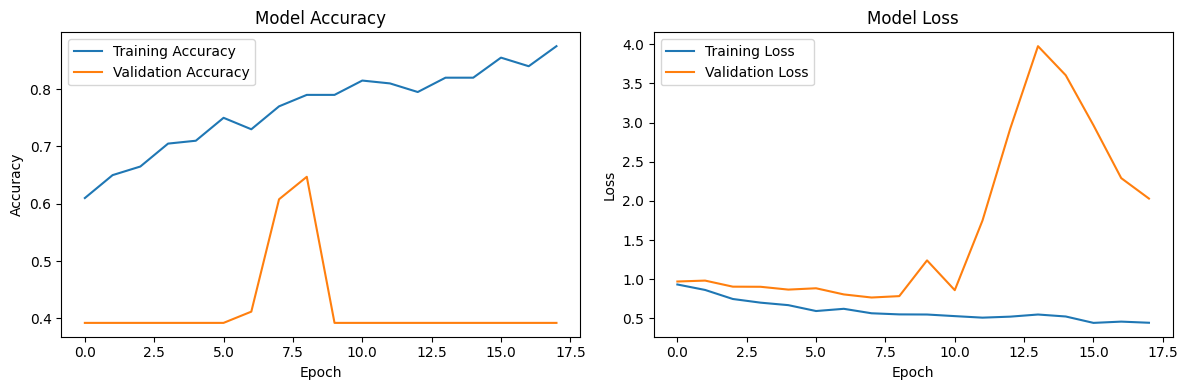

2/2 [==============================] - 0s 15ms/step
Optimal classification threshold: 0.6445


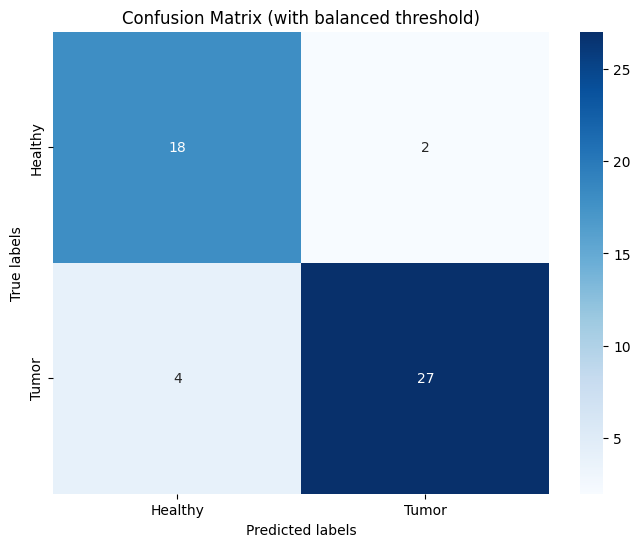

Test Accuracy (with balanced threshold): 0.8824


In [64]:
def main_balanced():
    """Main function with improvements for balanced predictions"""
    # Load and preprocess data
    dataset = BrainMRIDataset()
    
    # Get class distribution information
    tumor_count = np.sum(dataset.labels == 1)
    healthy_count = np.sum(dataset.labels == 0)
    print(f"Class distribution - Tumor: {tumor_count}, Healthy: {healthy_count}")
    
    # Preprocess images for quantum computing
    downsampled_images = dataset.preprocess_for_quantum()
    
    # Create quantum circuit
    circuit = create_quantum_circuit(n_qubits, n_layers)
    
    # Process images with quantum convolution
    q_images = process_dataset(downsampled_images, circuit)
    
    # Split into train and test sets with stratification
    from sklearn.model_selection import train_test_split as sklearn_split
    train_images, test_images, train_labels, test_labels = sklearn_split(
        q_images, dataset.labels, test_size=0.2, random_state=RANDOM_SEED, stratify=dataset.labels
    )
    
    # Compute inverse class weights (crucial for imbalanced data)
    class_weights = {
        0: (tumor_count + healthy_count) / (2 * healthy_count),
        1: (tumor_count + healthy_count) / (2 * tumor_count)
    }
    print(f"Class weights: {class_weights}")
    
    # Create enhanced model
    input_shape = q_images.shape[1:]
    model = create_enhanced_model(input_shape)
    
    # Better callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001
        )
    ]
    
    # Train with class weights and improved settings
    history = model.fit(
        train_images,
        train_labels,
        batch_size=batch_size,
        epochs=50,
        validation_data=(test_images, test_labels),
        verbose=1,
        class_weight=class_weights,
        callbacks=callbacks
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Use a custom threshold for predictions instead of 0.5
    y_pred_probs = model.predict(test_images)
    
    # Find the optimal threshold
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(test_labels, y_pred_probs)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal classification threshold: {optimal_threshold:.4f}")
    
    # Apply optimal threshold
    y_pred_binary = (y_pred_probs > optimal_threshold).astype(int)
    
    # Plot confusion matrix with balanced threshold
    cm = confusion_matrix(test_labels, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix (with balanced threshold)')
    plt.xticks([0.5, 1.5], ['Healthy', 'Tumor'])
    plt.yticks([0.5, 1.5], ['Healthy', 'Tumor'])
    plt.show()
    
    acc = accuracy_score(test_labels, y_pred_binary)
    print(f"Test Accuracy (with balanced threshold): {acc:.4f}")
    
    return model, test_images, test_labels

# Run the balanced model
model, test_images, test_labels = main_balanced()